In [3]:
import sys
sys.path.append('..')
from contrib.dmi.data import *
from contrib.dmi.load_data import *
from src.utils import *
from src.models import *


import matplotlib.pyplot as plt
import torch
import itertools

lon_min = -10
lon_max = 30
lat_min = 48
lat_max = 66


datamodule = BaseDataModule(input_da=load_data(path_obs="/DATASET/mbeauchamp/DMI/training_dataset/DMI-L3S_GHRSST-SSTsubskin-night_SST_UHR_NRT-NSEABALTIC.nc",
                                                        path_tgt="/DATASET/mbeauchamp/DMI/training_dataset/DMI-L3S_GHRSST-SSTsubskin-night_SST_UHR_NRT-NSEABALTIC.nc"),     
                            domains={'train': {'time': slice('2019-05-01', '2020-12-31',)},
                                     'val': {'time': [ slice('2021-01-01', '2021-01-31',),
                                                       slice('2021-04-01', '2021-04-30',),
                                                       slice('2021-07-01', '2021-07-31',),
                                                       slice('2021-10-01', '2021-10-31',) ]},
                                     'test': {'time': slice('2021-06-01', '2021-06-30',)}},
                            xrds_kw={'patch_dims': {'time': 7, 'lat': 240, 'lon': 240},
                                     'strides': {'time': 1, 'lat': 10, 'lon': 10},
                                     'strides_test': {'time': 1, 'lat': 200, 'lon': 200},
                                     'domain_limits':  dict(lon=slice(lon_min, lon_max,),
                                                            lat=slice(lat_min, lat_max,)),
                                     },
                            dl_kw={'batch_size': 2, 'num_workers': 1},
                            res=0.02,
                            pads=[False,False,True],
                            norm_stats =[283.8052,4.2381434])
datamodule.setup()

data_loader = datamodule.train_dataloader()
test_dataloader = datamodule.test_dataloader()

k=10
my_sample = next(itertools.islice(data_loader, k, None))
print(my_sample[0].shape)

/homes/m19beauc/miniconda3/envs/4dvarnet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([2, 7, 240, 240])


/tmp/ipykernel_3293930/946149312.py:10: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in p.axes.flat:


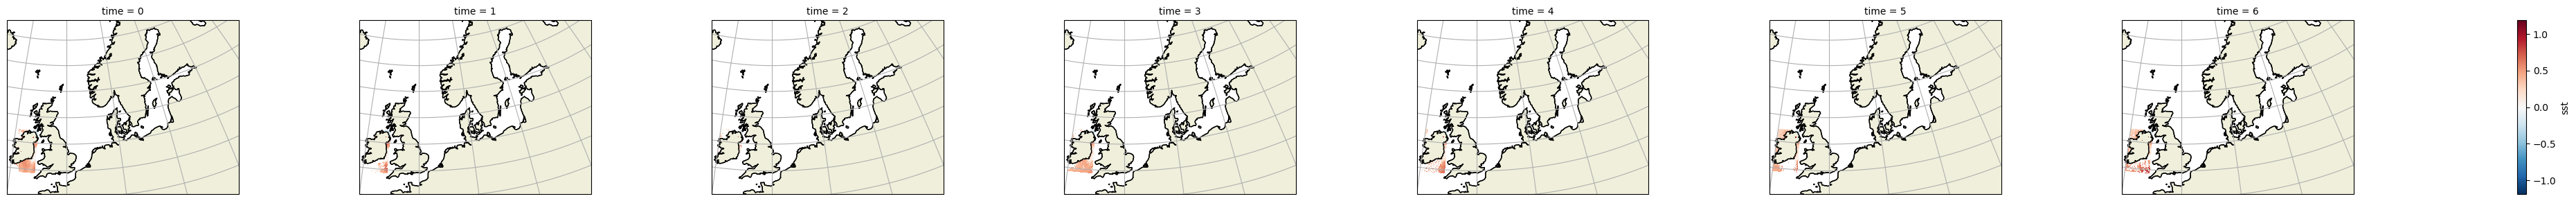

In [5]:
coords = datamodule.test_ds.get_coords()
# datamodule.train_ds[0].input has shape (15, 240, 240)
p = xr.Dataset(data_vars={'sst':(('time','lat','lon'),datamodule.test_ds[10].tgt)},
           coords={'time':np.arange(7),
                   'lon':coords[10].lon,
                   'lat':coords[10].lat}).sst.plot(transform=ccrs.PlateCarree(),
                                                   col='time',col_wrap=7,
                                                   aspect=datamodule.input_da.dims['lon'] / datamodule.input_da.dims['lat'], 
                                                   subplot_kws={'projection': ccrs.Orthographic(0, 45)})
for ax in p.axes.flat:
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
    ax.set_global()
    ax.gridlines()
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# 1. Display the patch strategy

## 1.1 Plot the training batches

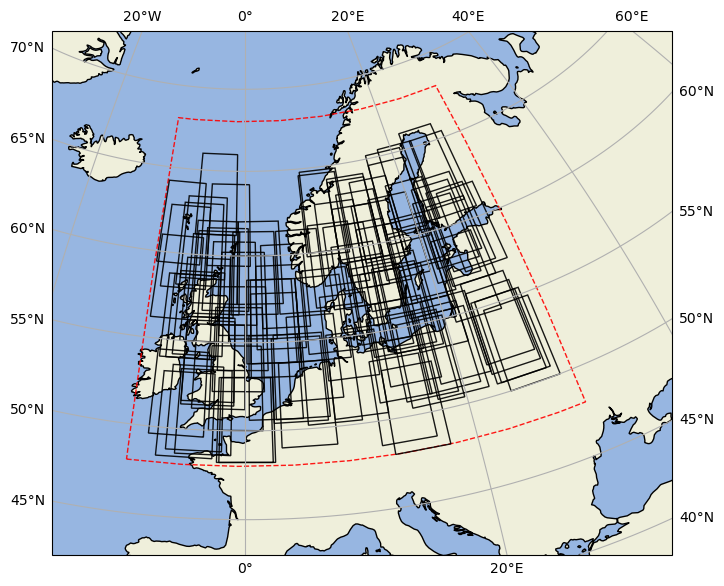

In [7]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from random import sample 

map_proj = ccrs.Orthographic(0, 45)
map_proj._threshold /= 100.

fig, ax = plt.subplots(figsize=(8,7),
                       subplot_kw=dict(projection=map_proj))
ax.add_feature(cartopy.feature.OCEAN, zorder=0)
ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
ax.set_global()
ax.gridlines(draw_labels=True)
ax.set_extent([-15, 35, 43, 71], crs=ccrs.PlateCarree())
lon_min = -10
lon_max = 30
lat_min = 48
lat_max = 66

coords = datamodule.train_ds.get_coords()

# Baltic
ax.add_patch(mpatches.Rectangle(xy=[lon_min, lat_min], width=40, height=20,
                                    edgecolor='red',
                                    linestyle="dashed",
                                    alpha=0.9,
                                    facecolor="none",
                                    transform=ccrs.PlateCarree()))

for i in range(0,100):
    # test1
    ax.add_patch(mpatches.Rectangle(xy=[coords[i].lon[0], coords[i].lat[0]], 
                                    width=datamodule.xrds_kw['patch_dims']['lon']*0.02,
                                    height=datamodule.xrds_kw['patch_dims']['lat']*0.02,
                                    edgecolor='black',
                                    facecolor="none",
                                    alpha=0.9,
                                    transform=ccrs.PlateCarree()))      
plt.show()

## 1.2 Plot the testing batches

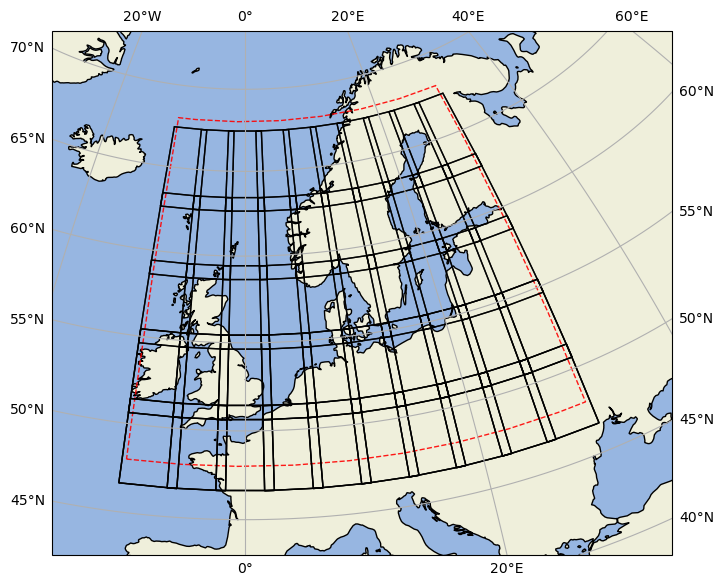

In [8]:
fig, ax = plt.subplots(figsize=(8,7),
                       subplot_kw=dict(projection=map_proj))
ax.add_feature(cartopy.feature.OCEAN, zorder=0)
ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
ax.set_global()
ax.gridlines(draw_labels=True)
ax.set_extent([-15, 35, 43, 71], crs=ccrs.PlateCarree())
lon_min = -10
lon_max = 30
lat_min = 48
lat_max = 66

coords = datamodule.test_ds.get_coords()

# Baltic
ax.add_patch(mpatches.Rectangle(xy=[lon_min, lat_min], width=40, height=20,
                                    edgecolor='red',
                                    linestyle="dashed",
                                    alpha=0.9,
                                    facecolor="none",
                                    transform=ccrs.PlateCarree()))

for i in range(120):
    ax.add_patch(mpatches.Rectangle(xy=[coords[i].lon[0], coords[i].lat[0]],
                                    width=datamodule.xrds_kw['patch_dims']['lon']*0.02,
                                    height=datamodule.xrds_kw['patch_dims']['lat']*0.02,
                                    edgecolor='black',
                                    facecolor="none",
                                    alpha=0.9,
                                    transform=ccrs.PlateCarree()))        

## 1.3 Plot the areas of interest

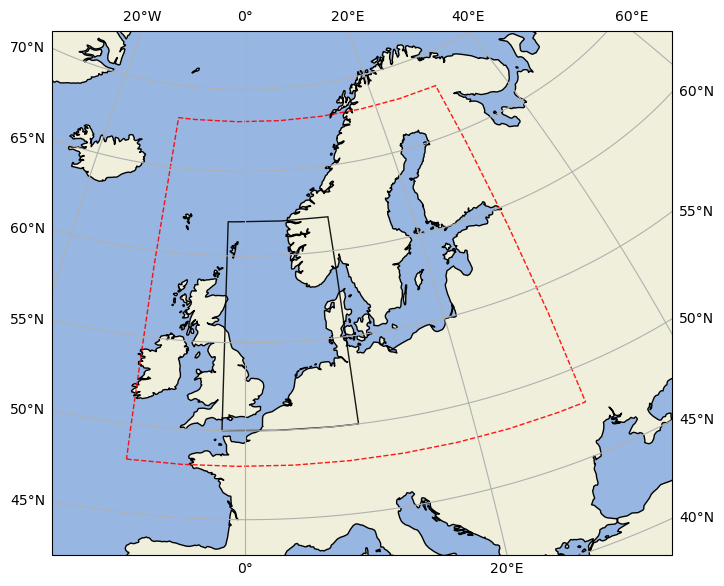

In [5]:
fig, ax = plt.subplots(figsize=(8,7),
                       subplot_kw=dict(projection=map_proj))
ax.add_feature(cartopy.feature.OCEAN, zorder=0)
ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
ax.set_global()
ax.gridlines(draw_labels=True)
ax.set_extent([-15, 35, 43, 71], crs=ccrs.PlateCarree())
lon_min = -10
lon_max = 30
lat_min = 48
lat_max = 66

coords = datamodule.test_ds.get_coords()

# Baltic
ax.add_patch(mpatches.Rectangle(xy=[lon_min, lat_min], width=40, height=20,
                                    edgecolor='red',
                                    linestyle="dashed",
                                    alpha=0.9,
                                    facecolor="none",
                                    transform=ccrs.PlateCarree()))
"""
# Domain #1
#'domain_limits':  dict(lon=slice(8, 20,),
#                       lat=slice(53.75, 65.75,))
ax.add_patch(mpatches.Rectangle(xy=[18,53.75], width=12, height=12,
                                    facecolor='blue',
                                    alpha=0.2,
                                    transform=ccrs.PlateCarree()))  
ax.add_patch(mpatches.Rectangle(xy=[8,53.75], width=12, height=12,
                                    facecolor='blue',
                                    alpha=0.2,
                                    transform=ccrs.PlateCarree()))
                                    

# Domain #2
#'domain_limits':  dict(lon=slice(14, 26,),
#                       lat=slice(53.75, 65.75,))
ax.add_patch(mpatches.Rectangle(xy=[14,53.75], width=12, height=12,
                                    facecolor='green',
                                    alpha=0.2,
                                    transform=ccrs.PlateCarree()))  
"""

# Domain #3
#'domain_limits':  dict(lon=slice(-2, 10,),
#                       lat=slice(50, 62,))
ax.add_patch(mpatches.Rectangle(xy=[-2,50], width=12, height=12,
                                    facecolor='none',
                                    ec="black",
                                    alpha=0.9,
                                    transform=ccrs.PlateCarree()))  

## 1.4 Create the datamodule for the 3 areas of interest

In [ ]:
# DM1
datamodule_dm1 = BaseDataModule_wgeo(input_da=load_data_wgeo(path_obs="/DATASET/mbeauchamp/DMI/training_dataset/DMI-L3S_GHRSST-SSTsubskin-night_SST_UHR_NRT-NSEABALTIC.nc",
                                                        path_tgt="/DATASET/mbeauchamp/DMI/training_dataset/DMI-L3S_GHRSST-SSTsubskin-night_SST_UHR_NRT-NSEABALTIC.nc",
                                                        path_oi="/DATASET/mbeauchamp/DMI/training_dataset/DMI-L4_GHRSST-SSTfnd-DMI_OI-NSEABALTIC.nc"),
                            domains={'train': {'time': slice('2019-05-01', '2020-12-31',)},
                                     'val': {'time': [ slice('2021-01-01', '2021-01-31',),
                                                       slice('2021-04-01', '2021-04-30',),
                                                       slice('2021-07-01', '2021-07-31',),
                                                       slice('2021-10-01', '2021-10-31',) ]},
                                     'test': {'time': slice('2021-01-01', '2021-12-31',)}},
                            xrds_kw={'patch_dims': {'time': 15, 'lat': 600, 'lon': 600},
                                     'strides': {'time': 1, 'lat': 500, 'lon': 500},
                                     'domain_limits':  dict(lon=slice(8, 30,),
                                                            lat=slice(53.75, 65.7499,))},
                            dl_kw={'batch_size': 2, 'num_workers': 1},
                            res=0.02,
                            norm_stats =[283.8052,4.2381434])
datamodule_dm1.setup()
test_dataloader_dm1 = datamodule_dm1.test_dataloader()

# DM2
datamodule_dm2 = BaseDataModule_wgeo(input_da=load_data_wgeo(path_obs="/DATASET/mbeauchamp/DMI/training_dataset/DMI-L3S_GHRSST-SSTsubskin-night_SST_UHR_NRT-NSEABALTIC.nc",
                                                        path_tgt="/DATASET/mbeauchamp/DMI/training_dataset/DMI-L3S_GHRSST-SSTsubskin-night_SST_UHR_NRT-NSEABALTIC.nc",
                                                        path_oi="/DATASET/mbeauchamp/DMI/training_dataset/DMI-L4_GHRSST-SSTfnd-DMI_OI-NSEABALTIC.nc"),
                            domains={'train': {'time': slice('2019-05-01', '2020-12-31',)},
                                     'val': {'time': [ slice('2021-01-01', '2021-01-31',),
                                                       slice('2021-04-01', '2021-04-30',),
                                                       slice('2021-07-01', '2021-07-31',),
                                                       slice('2021-10-01', '2021-10-31',) ]},
                                     'test': {'time': slice('2021-01-01', '2021-12-31',)}},
                            xrds_kw={'patch_dims': {'time': 15, 'lat': 600, 'lon': 600},
                                     'strides': {'time': 1, 'lat': 500, 'lon': 500},
                                     'domain_limits':  dict(lon=slice(14, 26,),
                                                            lat=slice(53.75, 65.75,))},
                            dl_kw={'batch_size': 2, 'num_workers': 1},
                            res=0.02,
                            norm_stats =[283.8052,4.2381434])
datamodule_dm2.setup()
test_dataloader_dm2 = datamodule_dm2.test_dataloader()

# DM3
datamodule_dm3 = BaseDataModule_wgeo(input_da=load_data_wgeo(path_obs="/DATASET/mbeauchamp/DMI/training_dataset/DMI-L3S_GHRSST-SSTsubskin-night_SST_UHR_NRT-NSEABALTIC.nc",
                                                        path_tgt="/DATASET/mbeauchamp/DMI/training_dataset/DMI-L3S_GHRSST-SSTsubskin-night_SST_UHR_NRT-NSEABALTIC.nc",
                                                        path_oi="/DATASET/mbeauchamp/DMI/training_dataset/DMI-L4_GHRSST-SSTfnd-DMI_OI-NSEABALTIC.nc"),
                            domains={'train': {'time': slice('2019-05-01', '2020-12-31',)},
                                     'val': {'time': [ slice('2021-01-01', '2021-01-31',),
                                                       slice('2021-04-01', '2021-04-30',),
                                                       slice('2021-07-01', '2021-07-31',),
                                                       slice('2021-10-01', '2021-10-31',) ]},
                                     'test': {'time': slice('2021-01-01', '2021-12-31',)}},
                            xrds_kw={'patch_dims': {'time': 15, 'lat': 600, 'lon': 600},
                                     'strides': {'time': 1, 'lat': 500, 'lon': 500},
                                     'domain_limits':  dict(lon=slice(-2, 10,),
                                                            lat=slice(50, 61.99,))},
                            dl_kw={'batch_size': 2, 'num_workers': 1},
                            res=0.02,
                            norm_stats =[283.8052,4.2381434])
datamodule_dm3.setup()
test_dataloader_dm3 = datamodule_dm3.test_dataloader()

# 2. Load the model and run

In [6]:
device = 'cpu'

from contrib.dmi.solver import BaseObsCost, BilinAEPriorCost, BilinAEPriorCost_wgeo

class GradSolver(nn.Module):
    def __init__(self, prior_cost, obs_cost, grad_mod, n_step, lr_grad=0.2, **kwargs):
        super().__init__()
        self.prior_cost = prior_cost
        self.obs_cost = obs_cost
        self.grad_mod = grad_mod

        self.n_step = n_step
        self.lr_grad = lr_grad

        self._grad_norm = None

    def init_state(self, batch, x_init=None):
        if x_init is not None:
            return x_init

        return batch.input.nan_to_num().detach().requires_grad_(True)

    def solver_step(self, state, batch, step):
        var_cost = self.prior_cost(state) + self.obs_cost(state, batch)
        grad = torch.autograd.grad(var_cost, state, create_graph=True)[0]

        gmod = self.grad_mod(grad)
        state_update = (
            1 / (step + 1) * gmod
                + self.lr_grad * (step + 1) / self.n_step * grad
        )

        return state - state_update

    def forward(self, batch):
        with torch.set_grad_enabled(True):
            state = self.init_state(batch)
            self.grad_mod.reset_state(batch.input)
            states = []
            for step in range(self.n_step):
                state = self.solver_step(state, batch, step=step)
                if not self.training:
                    state = state.detach().requires_grad_(True)
                states.append(state)
            #if not self.training:
            #    state = self.prior_cost.forward_ae(state)
            #state = self.prior_cost.forward_ae(state)
        return state, states


class GradSolver_wgeo(GradSolver):

    def init_state(self, batch, x_init=None):
        x_init = super().init_state(batch, x_init)
        coords_mask = torch.stack((batch.lat[:,0], batch.lon[:,0], batch.mask[:,0]), dim=1).to(x_init.device)
        return (x_init, coords_mask)

    def solver_step(self, state, batch, step):
        var_cost = self.prior_cost(state) + self.obs_cost(state[0], batch)
        x, coords_mask = state
        grad = torch.autograd.grad(var_cost, x, create_graph=True)[0]

        x_update = (
            1 / (step + 1) * self.grad_mod(grad)
            + self.lr_grad * (step + 1) / self.n_step * grad
        )
        state = (x - x_update, coords_mask)
        return state

    def forward(self, batch):
        with torch.set_grad_enabled(True):
            state = self.init_state(batch)
            self.grad_mod.reset_state(batch.input)

            states = []
            for step in range(self.n_step):
                state = self.solver_step(state, batch, step=step)
                if not self.training:
                    state = [s.detach().requires_grad_(True) for s in state]
                states.append(state[0])
            
            if not self.training:
                state = [self.prior_cost.forward_ae(state), state[1]]
        return state[0], states


In [7]:
# state only
"""
solver = GradSolver_wgeo(n_step=10,
                     lr_grad=1e-3,
                      prior_cost = BilinAEPriorCost_wgeo(dim_in=7,dim_hidden=32,
                                                    bilin_quad=False,downsamp=2),
                      obs_cost = BaseObsCost(),
                      grad_mod = ConvLstmGradModel(dim_in=7,dim_hidden=48)).to(device)
"""
# state only
solver = GradSolver(n_step=10,
                     lr_grad=1e-3,
                      prior_cost = BilinAEPriorCost(dim_in=7,dim_hidden=32,
                                                    bilin_quad=False,downsamp=2),
                      obs_cost = BaseObsCost(),
                      grad_mod = ConvLstmGradModel(dim_in=7,dim_hidden=64)).to(device)

## 2.1 Define the parameters

In [8]:
from IPython.display import clear_output
from torch.optim import Adam
from tqdm.autonotebook import tqdm

rec_weight = get_last_time_wei(patch_dims =  datamodule.xrds_kw['patch_dims'],
                                 crop= {'time': 0, 'lat': 50, 'lon': 50}, offset=1)
rec_weight = torch.from_numpy(rec_weight).to(device)

optim_weight = get_linear_time_wei(patch_dims = {'time': datamodule.xrds_kw['patch_dims']['time'],
                                                'lat': datamodule.xrds_kw['patch_dims']['lat'],
                                                'lon': datamodule.xrds_kw['patch_dims']['lon']},
                                 crop= {'time': 0, 'lat': 50, 'lon': 50}, offset=1)
optim_weight = torch.from_numpy(optim_weight).to(device)


def step(batch):
    if batch.tgt.isfinite().float().mean() < 0.05:
        return None, None

    loss, out = base_step(batch)
    
    grad_loss = weighted_mse(kfilts.sobel(out) - kfilts.sobel(batch.tgt), optim_weight)
    prior_cost = solver.prior_cost(solver.init_state(batch, out))
    training_loss = 50*loss  + 10000 * grad_loss + 10 * prior_cost
    print(50*loss, 10000 * grad_loss, 10 * prior_cost)
    
    return training_loss, out

def base_step(batch):

    out = solver(batch=batch)
    # mse loss
    loss = weighted_mse(out - batch.tgt, optim_weight)
    return loss, out
    
def weighted_mse(err, weight):
    err_w = err * weight[None, ...]
    non_zeros = (torch.ones_like(err) * weight[None, ...]) == 0.0
    err_num = err.isfinite() & ~non_zeros
    if err_num.sum() == 0:
        return torch.scalar_tensor(1000.0, device=err_num.device).requires_grad_()
    loss = F.mse_loss(err_w[err_num], torch.zeros_like(err_w[err_num]))
    return loss

In [9]:
#ckpt = torch.load('/homes/m19beauc/4dvarnet-starter/ckpt/sst_dmi_all_baltic_wgeo_linweight.ckpt', map_location=device)
ckpt = torch.load('/homes/m19beauc/4dvarnet-starter/ckpt/sst_dmi_baltic_dm3.ckpt', map_location=device)
solver_weights = {k[7:]: v for k, v in ckpt["state_dict"].items() if k.startswith("solver.")}
solver.load_state_dict(solver_weights)

<All keys matched successfully>

In [10]:
k=56
test_batch = next(itertools.islice(test_dataloader, k, None))
test_batch_ = test_batch
test_batch_ = test_batch_._replace(input=test_batch_.input.nan_to_num().to(device))
test_batch_ = test_batch_._replace(tgt=test_batch_.tgt.nan_to_num().to(device))
"""
test_batch_ = test_batch_._replace(lat=test_batch_.lat.nan_to_num().to(device))
test_batch_ = test_batch_._replace(lon=test_batch_.lon.nan_to_num().to(device))
test_batch_ = test_batch_._replace(mask=test_batch_.mask.nan_to_num().to(device))
"""
# 4DVarNets scheme  
out = solver(test_batch_)

/homes/m19beauc/miniconda3/envs/4dvarnet/lib/python3.10/site-packages/torch/autograd/__init__.py:276: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 802: system not yet initialized (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484808560/work/c10/cuda/CUDAFunctions.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


/tmp/ipykernel_2930312/1445816560.py:17: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  mappable = p.axes[0][0].collections[0]
/tmp/ipykernel_2930312/1445816560.py:24: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in p.axes.flat:


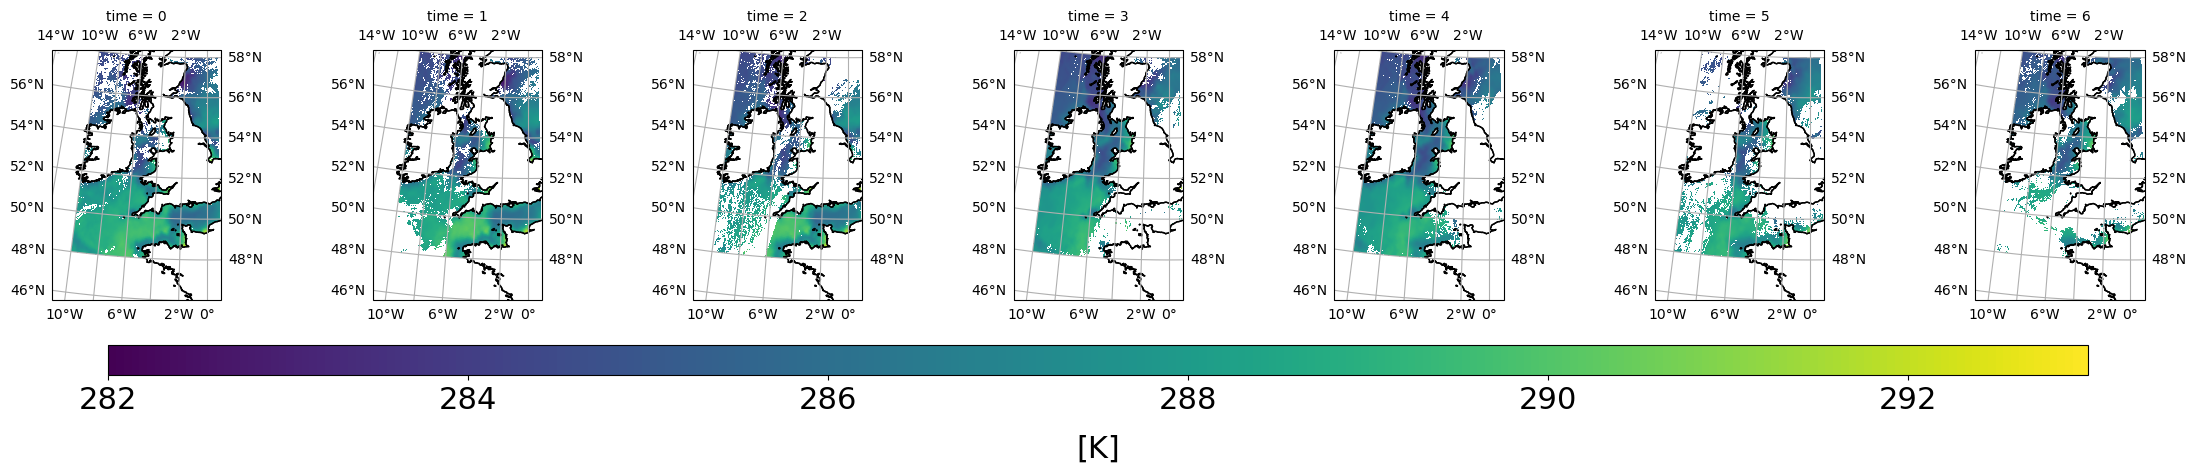

In [11]:
coords = datamodule.test_ds.get_coords()
m, s = [283.8052,4.2381434]
solver_steps = torch.stack(out[1],dim=0).detach().cpu().numpy()*s+m
solver_steps[0] = test_batch.input.detach().cpu().numpy()*s+m
# datamodule.train_ds[0].input has shape (15, 240, 240)
#plt.figure(figsize=(30,20))
p = xr.Dataset(data_vars={'sst':(('time','lat','lon'),test_batch.input[0,:,:,:].detach().cpu().numpy()*s+m)},
           coords={'time':np.arange(7),
                   'lon':coords[2*k].lon,
                   'lat':coords[2*k].lat}).sst.plot(transform=ccrs.PlateCarree(),
                                                   col='time',col_wrap=7,
                                                   vmin=282, vmax=293,
                                                   #aspect=datamodule.input_da.dims['lon'] / datamodule.input_da.dims['lat'], 
                                                   #subplot_kws={'projection': ccrs.Orthographic(0, 45)})
                                                   subplot_kws={'projection': map_proj},
                                                   add_colorbar=False)
mappable = p.axes[0][0].collections[0]
cax = plt.axes([0.05, -0.2, 0.9, 0.1])
cbar1 = plt.colorbar(mappable, cax=cax, orientation='horizontal')
cbar1.ax.tick_params(labelsize=22,axis="both")
cbar1.ax.set_title("[K]",fontsize=22,y=-3)

plt.subplots_adjust(wspace=.3)
for ax in p.axes.flat:
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black',facecolor="white")
    ax.set_global()
    ax.gridlines(draw_labels=True)
    ax.set_extent([np.min(coords[2*k].lon), 
                   np.max(coords[2*k].lon), 
                   np.min(coords[2*k].lat), 
                   np.max(coords[2*k].lat)], crs=ccrs.PlateCarree())

/tmp/ipykernel_2930312/1504805641.py:20: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  mappable = p.axes[0][0].collections[0]
/tmp/ipykernel_2930312/1504805641.py:27: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in p.axes.flat:


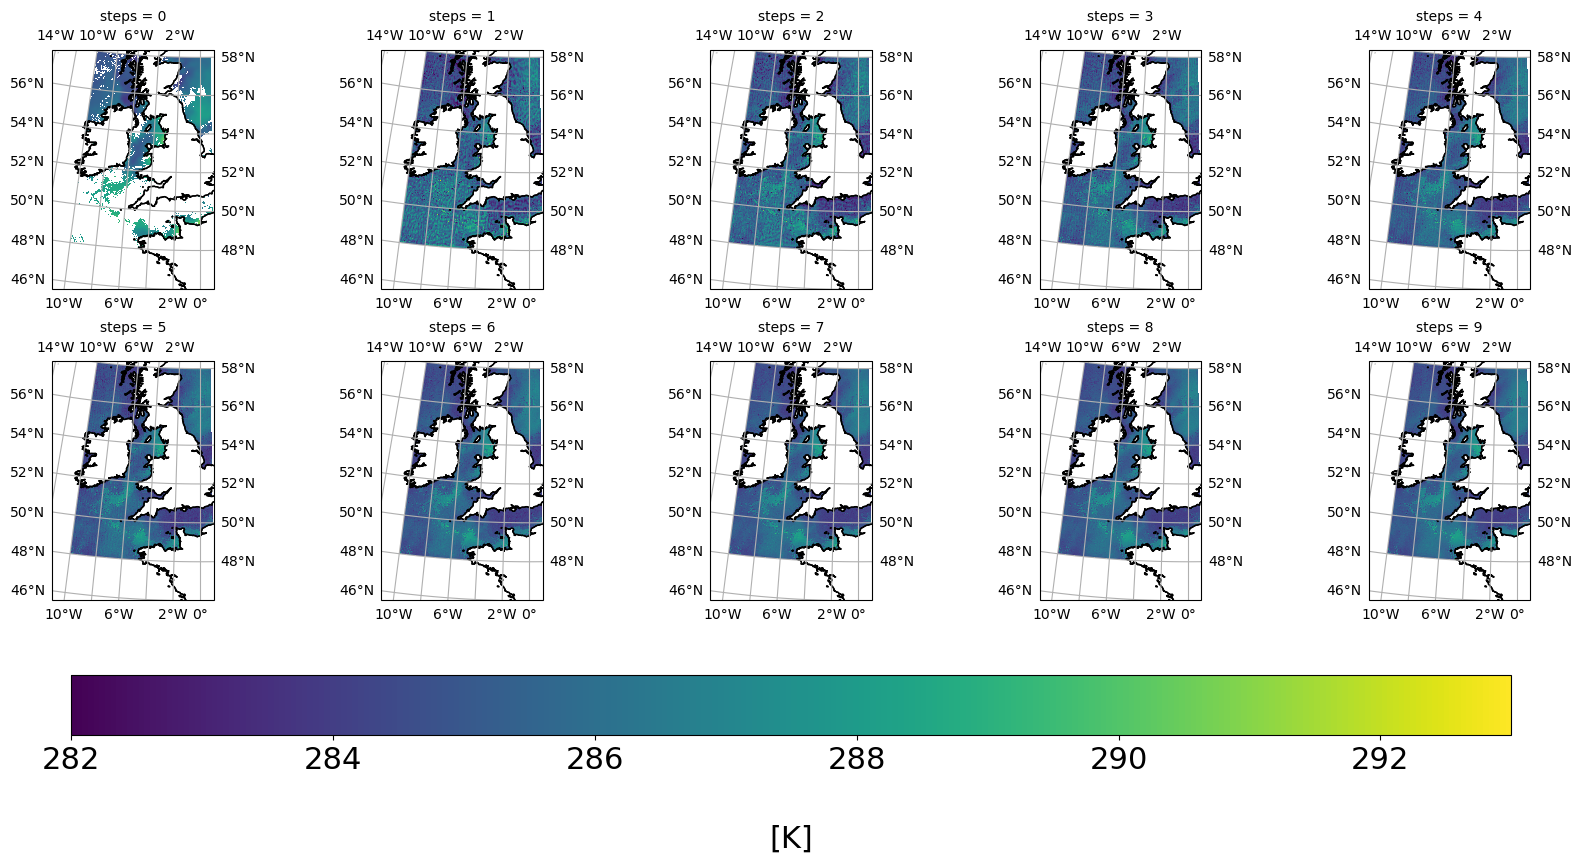

In [12]:
coords = datamodule.test_ds.get_coords()
m, s = [283.8052,4.2381434]
solver_steps = torch.stack(out[1],dim=0).detach().cpu().numpy()*s+m
solver_steps[0] = test_batch.input.detach().cpu().numpy()*s+m
solver_steps[:,:,:,0:100,:] = np.nan
solver_steps[:,:,:,:,0:50] = np.nan

# datamodule.train_ds[0].input has shape (15, 240, 240)
p = xr.Dataset(data_vars={'sst':(('steps','lat','lon'),solver_steps[:,0,6,:,:])},
           coords={'steps':np.arange(10),
                   'lon':coords[2*k].lon,
                   'lat':coords[2*k].lat}).sst.plot(transform=ccrs.PlateCarree(),
                                                   col='steps',col_wrap=5,
                                                   vmin=282, vmax=293,
                                                   #aspect=datamodule.input_da.dims['lon'] / datamodule.input_da.dims['lat'], 
                                                   #subplot_kws={'projection': ccrs.Orthographic(0, 45)})
                                                   subplot_kws={'projection': map_proj},
                                                   add_colorbar=False)

mappable = p.axes[0][0].collections[0]
cax = plt.axes([0.05, -0.2, 0.9, 0.1])
cbar1 = plt.colorbar(mappable, cax=cax, orientation='horizontal')
cbar1.ax.tick_params(labelsize=22,axis="both")
cbar1.ax.set_title("[K]",fontsize=22,y=-2)

plt.subplots_adjust(wspace=.3,hspace=.3)
for ax in p.axes.flat:
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black',facecolor="white")
    ax.set_global()
    ax.gridlines(draw_labels=True)
    ax.set_extent([np.min(coords[2*k].lon), 
                   np.max(coords[2*k].lon), 
                   np.min(coords[2*k].lat), 
                   np.max(coords[2*k].lat)], crs=ccrs.PlateCarree())

## 2.2 Run test dataset, output NetCDF and metrics

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

def run_test(test_dataloader):

    test_data = []

    def test_quantities(self):
        return ['inp', 'tgt', 'out']

    m, s = [283.8052,4.2381434] 

    for k in range(len(test_dataloader)):
    
        print(str(k)+'/'+str(len(test_dataloader)))
        test_batch = next(itertools.islice(test_dataloader, k, None))
        
        test_batch_ = test_batch
        test_batch_ = test_batch_._replace(input=test_batch_.input.nan_to_num().to(device))
        test_batch_ = test_batch_._replace(tgt=test_batch_.tgt.nan_to_num().to(device))
        
        # 4DVarNets scheme  
        out = solver(test_batch_)
    
        test_data.append(torch.stack(
        [
            test_batch_.input.detach().cpu() * s + m,
            test_batch_.tgt.detach().cpu() * s + m,
            out.squeeze(dim=-1).detach().cpu() * s + m,
        ],
        dim=1,
        )) 
        
        test_batch_ = None
        out = None
        gc.collect()
        torch.cuda.empty_cache()

    # reconstruct mean
    if isinstance(test_dataloader,list):
        rec_da = test_dataloader[0].dataset.reconstruct(
            test_data, rec_weight.cpu().numpy()
        )
    else:
        rec_da = test_dataloader.dataset.reconstruct(
                test_data, rec_weight.cpu().numpy()
        )
    rec_da = test_dataloader.dataset.reconstruct(test_data, rec_weight.cpu().numpy())
    test_data = rec_da.assign_coords(
            dict(v0=test_quantities)
        ).to_dataset(dim='v0')

    return test_data

In [ ]:
import os 
test_data = run_test(test_dataloader)
file = "/DATASET/mbeauchamp/DMI/4DVarNet_outputs/DMI-L4_GHRSST-SSTfnd-DMI_4DVarNet-NSEABALTIC_2021_all_baltic_wgeo_linweight_dt15_all.nc"
if not os.path.isfile(file):
    test_data = run_test(test_dataloader)
    test_data.to_netcdf(file)

In [ ]:
file = "/DATASET/mbeauchamp/DMI/4DVarNet_outputs/DMI-L4_GHRSST-SSTfnd-DMI_4DVarNet-NSEABALTIC_2021_all_baltic_wgeo_linweight_dt15_dm1.nc"
if not os.path.isfile(file):
    test_data_dm1 = run_test(test_dataloader_dm1)
    test_data_dm1.to_netcdf(file)

In [ ]:
file = "/DATASET/mbeauchamp/DMI/4DVarNet_outputs/DMI-L4_GHRSST-SSTfnd-DMI_4DVarNet-NSEABALTIC_2021_all_baltic_wgeo_linweight_dt15_dm2.nc"
if not os.path.isfile(file):
    test_data_dm2 = run_test(test_dataloader_dm2)
    test_data_dm2.to_netcdf(file)

In [ ]:
file = "/DATASET/mbeauchamp/DMI/4DVarNet_outputs/DMI-L4_GHRSST-SSTfnd-DMI_4DVarNet-NSEABALTIC_2021_all_baltic_wgeo_linweight_dt15_dm3.nc"
if not os.path.isfile(file):
    test_data_dm3 = run_test(test_dataloader_dm3)
    test_data_dm3.to_netcdf(file)

# 3. Plot the metrics

In [ ]:
test_data.out.plot(col="time",col_wrap=5)
! python /DATASET/mbeauchamp/DMI/codes/plot_metrics.py all_baltic_wgeo_linweight_dt15
! python /DATASET/mbeauchamp/DMI/codes/plot_metrics.py all_baltic_wgeo_linweight_dt15_dm1
! python /DATASET/mbeauchamp/DMI/codes/plot_metrics.py all_baltic_wgeo_linweight_dt15_dm2
! python /DATASET/mbeauchamp/DMI/codes/plot_metrics.py all_baltic_wgeo_linweight_dt15_dm3